Go to Files, Go to content, and then upload 'seg_train.zip' and 'seg_test.zip' to content. The files will be auto extracted. Then, create an empty file named 'model' under content. This where the model will be saved. In the testing sequence, input value for the test set number under 2000. If the output of the model is too vague, it will display 'No prediction'. Therefore I have chosen the number of training iterations to be a million times so that it can be accurate

# **Formatting of training data into pixel values to be inputted into the Neural Network**

In [7]:
import torch
import os
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import random

from zipfile import ZipFile
file_path_zip = '/content/seg_train.zip'
with ZipFile(file_path_zip, 'r') as zip:
  zip.extractall()
  print('File extracted')

data = []

def create_training_data():
  file_path = '/content/seg_train'
  types = ['buildings','forest','glacier','mountain','sea','street']
  for category in types:
    class_num = types.index(category)
    path = os.path.join(file_path,category)
    for img in os.listdir(path):
      img_array = cv2.imread(os.path.join(path,img), 0)
      if img_array.shape == (150,150):
        img_array = np.reshape(img_array,22500)
        data.append([img_array,class_num])
        #data = list(data)

create_training_data()
data = np.asarray(data)
random.shuffle(data)
x = data[:,0]
print(x.shape)
y = torch.zeros(13986,6)
x = x.tolist()
Y = data[:,1]
Y = Y.tolist()

x = torch.Tensor(x)
x = x/255
y_data = torch.Tensor(Y)

for n in range(13986):
  if y_data[n] == 5:
    y[n,5] += 1
  elif y_data[n] == 4:
    y[n,4] += 1
  elif y_data[n] == 3:
    y[n,3] += 1
  elif y_data[n] == 2:
    y[n,2] += 1
  elif y_data[n] == 1:
    y[n,1] += 1
  elif y_data[n] == 0:
    y[n,0] += 1


Done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(13986,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


# **Creation of Convolutional Neural Network Model and Training the model using Training Data**

In [11]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import random


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=4321)

class NeuralNetwork(nn.Module):
  def __init__(self,n_input,n_hidden_1,n_hidden_2,n_output):
    super(NeuralNetwork,self).__init__()
    self.l1 = nn.Linear(n_input,n_hidden_1)
    self.softmax = nn.Softmax()
    self.l2 = nn.Linear(n_hidden_1,n_hidden_2)
    self.l3 = nn.Linear(n_hidden_2,n_output)

  def forward(self,X):
    out = self.l1(X)
    out = self.softmax(out)
    out = self.l2(out)
    out = self.softmax(out)
    out = self.l3(out)
    out = self.softmax(out)
    return out

input_features = 22500
hidden_feature_1 = 128
hidden_feature_2 = 128
output_features = 6
model = NeuralNetwork(input_features,hidden_feature_1,hidden_feature_2,output_features)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.005
optimiser = torch.optim.Adam(model.parameters(),lr=learning_rate)
iterations = 1000000

for epoch in range(iterations+1):
  y_predicted = model(x)
  loss = criterion(y_predicted,y)
  loss.backward()
  optimiser.step()
  print('epoch: ' , epoch)
  if epoch == iterations:
    print('Training Complete')

torch.save(model,'/content/model')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch:  0
epoch:  1
epoch:  2
epoch:  3
Training Complete


# **Testing of Convolutional Neural Network in Testing Sequence using Testing Data**

File extracted
Test set number: 1000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


No Prediction
Actual feaure: glacier


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


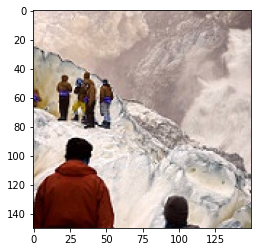

In [51]:
import torch
import os
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import random

torch.load('/content/model')
from zipfile import ZipFile
file_path_zip_test = '/content/seg_test.zip'
with ZipFile(file_path_zip_test, 'r') as zip:
  zip.extractall()
  print('File extracted')

data_test = []
data_color = []
test_set = int(input('Test set number: '))

def testing_data():
  file_path = '/content/seg_test'
  types = ['buildings','forest','glacier','mountain','sea','street']
  for category in types:
    class_num = types.index(category)
    path = os.path.join(file_path,category)  
    for img in os.listdir(path):
      img_array_test = cv2.imread(os.path.join(path,img), 0)
      img_array_color = cv2.imread(os.path.join(path,img), 1)
      
      if img_array_test.shape == (150,150):
        img_array_test_reshape = np.reshape(img_array_test,22500)
        img_array_color_reshape = np.reshape(img_array_color,(150,150,3))
        data_test.append([img_array_test_reshape,class_num])
        data_color.append(img_array_color)

testing_data()
data_test = np.asarray(data_test)
plt.imshow(data_color[test_set])
x_test = data_test[:,0]
y_test = torch.zeros(1000,6)
x_test = x_test.tolist()
Y_test = data_test[:,1]
Y_test = Y_test.tolist()
x_test = torch.Tensor(x_test)
x_test = x_test/255
y_test_data = torch.Tensor(Y_test)




def test(x_test,Y_test):
  if model(x_test[test_set])[0] > 0.6:
    print('Predicted feature: buildings')
  elif model(x_test[test_set])[1] > 0.6:
    print('Predicted feature: forest')
  elif model(x_test[test_set])[2] > 0.6:
    print('Predicted feature: glacier')
  elif model(x_test[test_set])[3] > 0.6:
    print('Predicted feature: mountain')
  elif model(x_test[test_set])[4] > 0.6:
    print('Predicted feature: sea')
  elif model(x_test[test_set])[5] > 0.6:
    print('Predicted feature: street')
  else:
    print('No Prediction')

  if Y_test[test_set] == 0:
    print('Actual feature: buildings')
  elif Y_test[test_set] == 1:
    print('Actual feature: forest')
  elif Y_test[test_set] == 2:
    print('Actual feaure: glacier')
  elif Y_test[test_set] == 3:
    print('Actual feature: mountain')
  elif Y_test[test_set] == 4:
    print('Actual feature: sea')
  elif Y_test[test_set] == 5:
    print('Actual feature: street')

test(x_test,Y_test)